In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
def plot_learning_curve(estimator, title, X, y, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

def train_and_evaluate(df, features):
    X = df[features]
    y = df['Thought']
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features)
        ])
    
    classifiers = {
        'RandomForest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'GradientBoosting': GradientBoostingClassifier()
    }

    param_grids = {
        'RandomForest': {
            'classifier__n_estimators':  [19, 50, 100, 200],
            'classifier__max_depth': [None, 3, 5, 10],
            'classifier__min_samples_split': [2, 10, 20]
            'classifier__criterion': ['gini', 'entropy', 'mse']
        },
        'KNN': {
            'classifier__n_neighbors': [5, 20, 50, 100, 120],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'minkowski'],
        },
        'GradientBoosting': {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__learning_rate': [0.01, 0.1, 0.5, 1],
            'classifier__max_depth': [3, 5, 10]
        }
    }
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    best_classifiers = {}
    best_params = {}
    cv_scores = {}
    predicted_labels = {}
    training_scores = {}

    for clf_name in classifiers.keys():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifiers[clf_name])
        ])
        
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[clf_name], cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
        
        oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
        
        for train_index, val_index in stratified_kfold.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            X_resampled, y_resampled = oversampler.fit_resample(X_train_fold, y_train_fold)
            grid_search.fit(X_resampled, y_resampled)
        
        best_classifiers[clf_name] = grid_search.best_estimator_
        best_params[clf_name] = grid_search.best_params_
        
        cv_score = cross_val_score(best_classifiers[clf_name], X, y, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
        cv_scores[clf_name] = cv_score.mean()
        predicted_labels[clf_name] = best_classifiers[clf_name].predict(X_test)

        training_scores[clf_name] = best_classifiers[clf_name].score(X_test, y_test)
        
        plot_learning_curve(best_classifiers[clf_name], f"Learning Curves ({clf_name})", X_train, y_train, cv=stratified_kfold)
    
    return best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_test


# 0-180

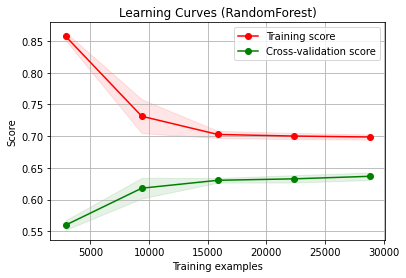

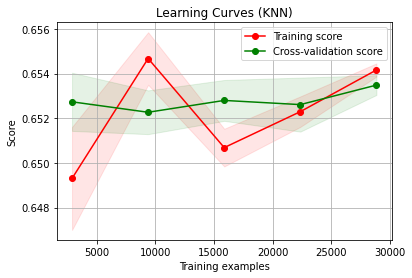

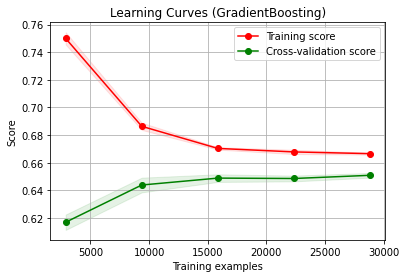

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_4_7_FC6'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_4_7_FC6'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=80))]), 'GradientBoosting': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_4_7_FC6'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=1

In [3]:
file_path = '/Users/aydanyagublu/eeglab2023.1/PROPER/powerTrials180.csv'
df = pd.read_csv(file_path)

features = ['avg_power_4_7_FC6']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)

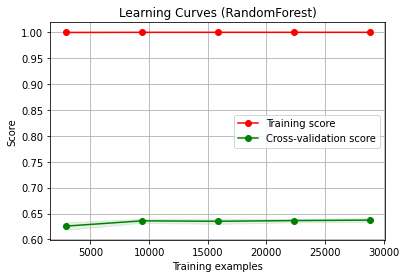

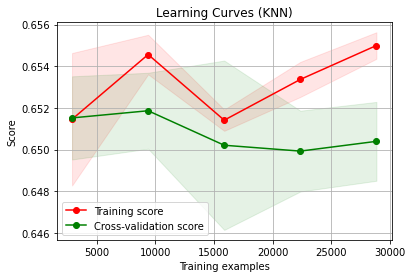

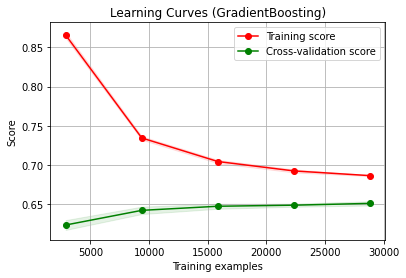

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_F8',
                                                   'avg_power_8_12_AF3',
                                                   'avg_power_8_12_FC1',
                                                   'avg_power_8_12_FC2',
                                                   'avg_power_8_12_FC6'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_F8',
                                                   'avg_power_8_12_AF3',
                                                   'avg_

In [4]:
features = ['avg_power_8_12_F8', 'avg_power_8_12_AF3', 'avg_power_8_12_FC1', 'avg_power_8_12_FC2', 'avg_power_8_12_FC6']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)


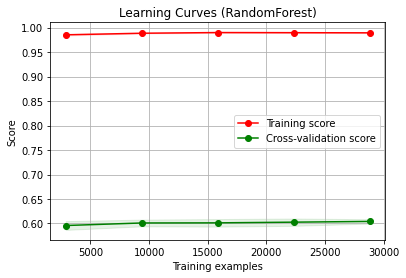

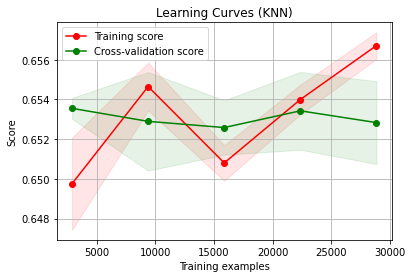

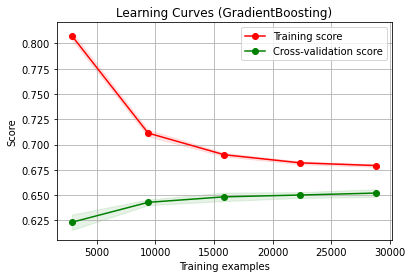

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_FC1',
                                                   'avg_power_13_30_FC5'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_FC1',
                                                   'avg_power_13_30_FC5'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=80))]), 'GradientBoosting': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                           

In [5]:
features = ['avg_power_13_30_FC1', 'avg_power_13_30_FC5']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)

# 180-350

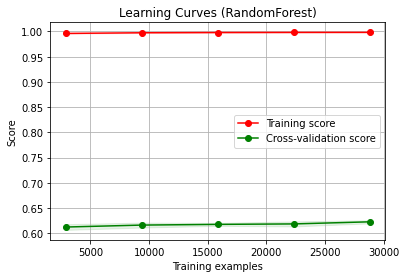

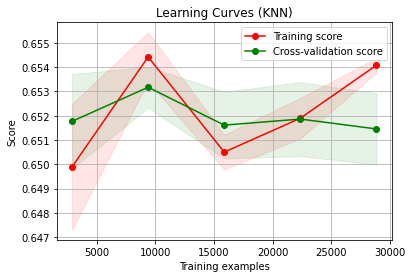

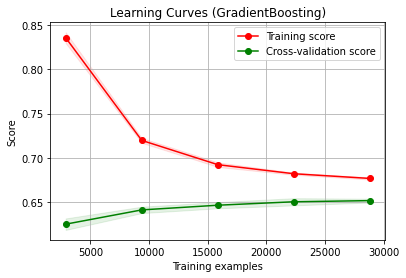

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_4_7_Pz',
                                                   'avg_power_4_7_FC1',
                                                   'avg_power_4_7_P4'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_4_7_Pz',
                                                   'avg_power_4_7_FC1',
                                                   'avg_power_4_7_P4'])])),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=80))]), 'GradientBoosting': Pip

In [6]:
file_path = '/Users/aydanyagublu/eeglab2023.1/PROPER/powerTrialsOG.csv'
df = pd.read_csv(file_path)

features = ['avg_power_4_7_Pz', 'avg_power_4_7_FC1', 'avg_power_4_7_P4']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)

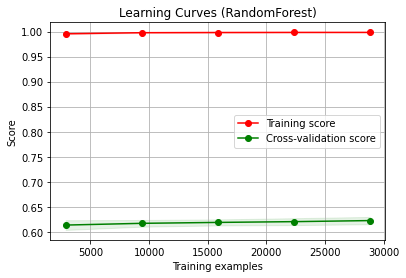

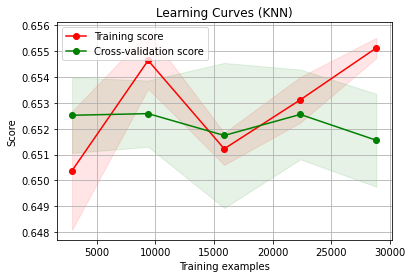

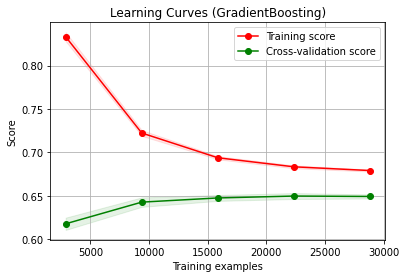

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_Pz',
                                                   'avg_power_8_12_FC1',
                                                   'avg_power_8_12_P4'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_Pz',
                                                   'avg_power_8_12_FC1',
                                                   'avg_power_8_12_P4'])])),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=80))]), 'GradientBoosting

In [7]:
features = ['avg_power_8_12_Pz', 'avg_power_8_12_FC1', 'avg_power_8_12_P4']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)

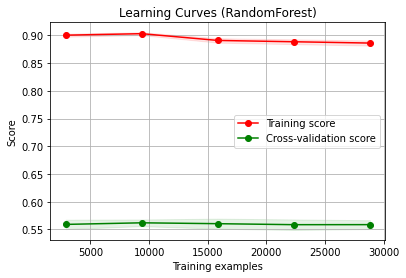

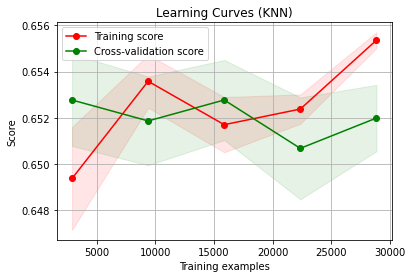

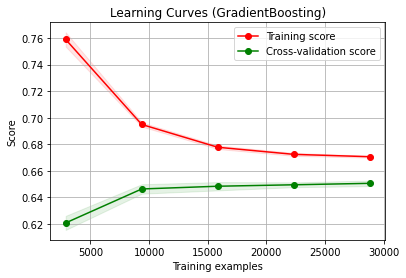

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_P4'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_P4'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=80))]), 'GradientBoosting': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_P4'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimator

In [8]:
features = ['avg_power_13_30_P4']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)

# 350 - 600ms

In [9]:
# file_path = '/Users/aydanyagublu/eeglab2023.1/PROPER/powerTrials600.csv'
# df = pd.read_csv(file_path)

# features = ['avg_power_4_7_F3', 'avg_power_4_7_Fz', 'avg_power_4_7_FC6']
# best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

# print("Best Classifiers: ", best_classifiers)
# print("Best Parameters: ", best_params)
# print("Cross-Validation Scores: ", cv_scores)
# print("Training Scores: ", training_scores)

# for clf_name, y_pred in predicted_labels.items():
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     specificity = tn / (tn + fp)
    
#     print(f"Classifier: {clf_name}")
#     print("Precision:", precision_score(y_true, y_pred))
#     print("Recall (Sensitivity):", recall_score(y_true, y_pred))
#     print("F1 Score:", f1_score(y_true, y_pred))
#     print("Specificity:", specificity)

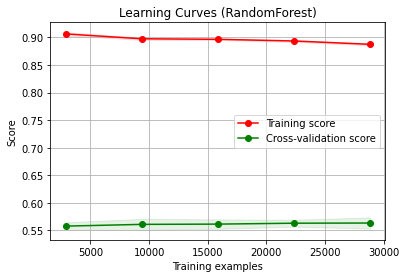

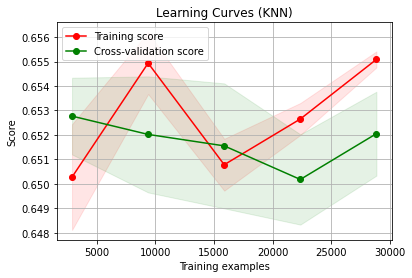

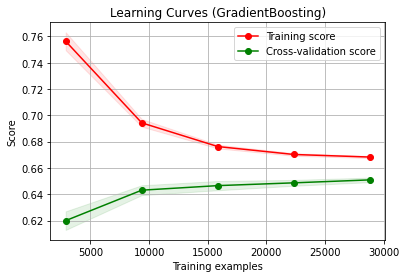

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_P4'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_P4'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=80))]), 'GradientBoosting': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_8_12_P4'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=150,
                                            random_sta

In [10]:
file_path = '/Users/aydanyagublu/eeglab2023.1/PROPER/powerTrials600.csv'
df = pd.read_csv(file_path)

features = ['avg_power_8_12_P4']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)

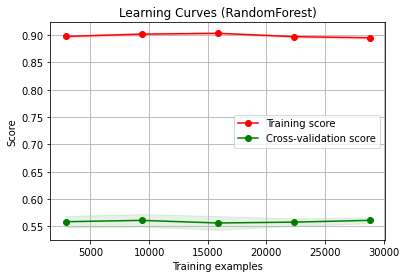

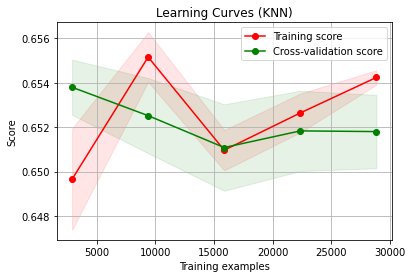

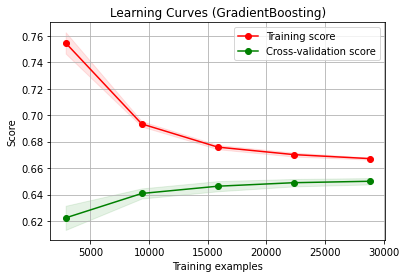

Best Classifiers:  {'RandomForest': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_FC5'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, random_state=42))]), 'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_FC5'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=80))]), 'GradientBoosting': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_power_13_30_FC5'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=150,
                                            rand

In [11]:
features = ['avg_power_13_30_FC5']
best_classifiers, best_params, cv_scores, training_scores, predicted_labels, y_true = train_and_evaluate(df, features)

print("Best Classifiers: ", best_classifiers)
print("Best Parameters: ", best_params)
print("Cross-Validation Scores: ", cv_scores)
print("Training Scores: ", training_scores)

for clf_name, y_pred in predicted_labels.items():
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"Classifier: {clf_name}")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall (Sensitivity):", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Specificity:", specificity)